In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install netCDF4

In [ ]:
#STEP1 Extract data from DS, understand what it there.
from netCDF4 import Dataset, chartostring
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.tri as mtri

In [ ]:

DRIVE_ROOT = "/content/drive/MyDrive/DynamicsTensors"
REPO_ROOT  = f"{DRIVE_ROOT}/bstt2"
DATA_DIR   = f"{DRIVE_ROOT}/data"
OUT_DIR    = f"{DRIVE_ROOT}/outputs"

train_path = os.path.join(DATA_DIR, "train_data.e")
test_path  = os.path.join(DATA_DIR, "test_data_2.e")

In [ ]:
for path in [train_path, test_path]:
    print("\n=== File:", os.path.basename(path), "===\n")
    ds = Dataset(path, "r")

    # Basic dims and time
    num_dim   = ds.dimensions.get("num_dim").size        if "num_dim"   in ds.dimensions else None
    num_nodes = ds.dimensions.get("num_nodes").size      if "num_nodes" in ds.dimensions else None
    num_elem  = ds.dimensions.get("num_elem").size       if "num_elem"  in ds.dimensions else None
    n_steps   = ds.dimensions.get("time_step").size      if "time_step" in ds.dimensions else 0
    print(f"num_dim={num_dim}, num_nodes={num_nodes}, num_elem={num_elem}, time_steps={n_steps}")

    # Time
    if "time_whole" in ds.variables:
        times = ds.variables["time_whole"][:]
        print(f"time_whole: shape={times.shape} example={times[:3]}")

    if "name_nod_var" in ds.variables:
        names = chartostring(ds.variables["name_nod_var"][:]).tolist()
        names = [s.strip() for s in names]
        print("nodal var names:", names)
    else:
        print("nodal var names: (none declared)")

    keys = sorted(ds.variables.keys())
    print("\nvariable keys (subset):", keys[:15], "..." if len(keys)>15 else "")

    nod_keys = [k for k in keys if k.startswith("vals_nod_var")]
    if nod_keys:
        k0 = nod_keys[0]
        print(f"\nExample nodal values: ds.variables['{k0}'][:] -> shape", ds.variables[k0].shape,
              "(expected (time_step, num_nodes))")

    for ckey in ["coordx","coordy","coordz"]:
        if ckey in ds.variables:
            print(f"{ckey}: shape", ds.variables[ckey].shape)

    conn_keys = [k for k in keys if k.startswith("connect")]
    if conn_keys:
        print("connectivity keys:", conn_keys[:5])

    ds.close()

print("\n# Extraction patterns :")
print("times      = ds.variables['time_whole'][:]                 # (time_step,)")
print("xcoord     = ds.variables.get('coordx')[:]                  # (num_nodes,) if present")
print("ycoord     = ds.variables.get('coordy')[:]                  # (num_nodes,) if present")
print("u_time     = ds.variables['vals_nod_var1'][:]               # (time_step, num_nodes) for 1st nodal var")
print("# map index→name: chartostring(ds.variables['name_nod_var'][:]).tolist()")



=== File: train_data.e ===

num_dim=2, num_nodes=6569, num_elem=6384, time_steps=5541
time_whole: shape=(5541,) example=[0. 1. 2.]
nodal var names: ['V_y', 'V_x', 'P']

variable keys (subset): ['connect1', 'coor_names', 'coordx', 'coordy', 'eb_names', 'eb_prop1', 'eb_status', 'elem_num_map', 'elem_ss1', 'elem_ss2', 'elem_ss3', 'elem_ss4', 'name_nod_var', 'node_num_map', 'qa_records'] ...

Example nodal values: ds.variables['vals_nod_var1'][:] -> shape (5541, 6569) (expected (time_step, num_nodes))
coordx: shape (6569,)
coordy: shape (6569,)
connectivity keys: ['connect1']

=== File: test_data_2.e ===

num_dim=2, num_nodes=6569, num_elem=6384, time_steps=1409
time_whole: shape=(1409,) example=[0. 1. 2.]
nodal var names: ['V_y', 'V_x', 'P']

variable keys (subset): ['connect1', 'coor_names', 'coordx', 'coordy', 'eb_names', 'eb_prop1', 'eb_status', 'elem_num_map', 'elem_ss1', 'elem_ss2', 'elem_ss3', 'elem_ss4', 'name_nod_var', 'node_num_map', 'qa_records'] ...

Example nodal values: ds.v

In [ ]:

def plot_flow_snapshot(path, t_index=0, quiver_frac=0.03, probe_node=None):
    ds = Dataset(path, "r")
    x = ds.variables["coordx"][:]
    y = ds.variables["coordy"][:]

    conn_keys = [k for k in ds.variables.keys() if k.startswith("connect")]
    assert conn_keys, "No connectivity array ('connect*') found."
    conn = np.asarray(ds.variables[conn_keys[0]][:], dtype=int) - 1
    if conn.shape[1] == 3:
        tri_conn = conn
    elif conn.shape[1] == 4:
        tri_conn = np.vstack([conn[:, [0, 1, 2]],
                              conn[:, [0, 2, 3]]])
    else:
        raise ValueError(f"Unsupported element with {conn.shape[1]} nodes (expected 3 or 4).")
    tri = mtri.Triangulation(x, y, triangles=tri_conn)

    names = []
    if "name_nod_var" in ds.variables:
        names = [s.strip() for s in chartostring(ds.variables["name_nod_var"][:]).tolist()]
    def _idx(name, default):
        for i, n in enumerate(names, start=1):
            if n == name or n.lower() == name.lower():
                return i
        return default
    ix_vy = _idx("V_y", 1)
    ix_vx = _idx("V_x", 2)

    # Snapshot
    Vy_t = ds.variables[f"vals_nod_var{ix_vy}"][t_index, :]
    Vx_t = ds.variables[f"vals_nod_var{ix_vx}"][t_index, :]
    ds.close()

    speed = np.sqrt(Vx_t**2 + Vy_t**2)

    # Downsample for quiver
    n = x.size
    step = max(1, int(round(1.0 / max(quiver_frac, 1e-6))))
    q_idx = np.arange(0, n, step)

    # Figure: heatmap (|V|) + quiver
    fig, ax = plt.subplots(figsize=(15, 10))
    # Heatmap on unstructured mesh
    tpc = ax.tripcolor(tri, speed, shading="gouraud")
    cb = plt.colorbar(tpc, ax=ax, shrink=0.9, label="|V|")
    # Quiver on top
    ax.quiver(
        x[q_idx], y[q_idx], Vx_t[q_idx], Vy_t[q_idx],
        angles="xy", scale_units="xy", scale=1, width=0.002,
        alpha=0.9, zorder=3
    )
    ax.set_aspect("equal", adjustable="box")
    ax.set_title(f"{os.path.basename(path)} | t={t_index}")
    ax.set_xlabel("x"); ax.set_ylabel("y")
    fig.tight_layout()
    plt.show()

def plot_heatmap_contours(path, t_index=0, field="speed", levels=20):
    ds = Dataset(path, "r")
    x = ds.variables["coordx"][:]
    y = ds.variables["coordy"][:]

    conn_keys = [k for k in ds.variables.keys() if k.startswith("connect")]
    assert conn_keys, "No 'connect*' array found in file."
    conn = ds.variables[conn_keys[0]][:] - 1
    conn = np.asarray(conn, dtype=int)
    if conn.shape[1] == 3:
        tri_conn = conn
    elif conn.shape[1] == 4:
        tri_conn = np.vstack([conn[:, [0, 1, 2]],
                            conn[:, [0, 2, 3]]])
    else:
        raise ValueError(f"Unsupported element with {conn.shape[1]} nodes (expected 3 or 4).")

    tri = mtri.Triangulation(x, y, triangles=tri_conn)

    names = []
    if "name_nod_var" in ds.variables:
        names = [s.strip() for s in chartostring(ds.variables["name_nod_var"][:]).tolist()]
    def _idx(name, default):
        for i, n in enumerate(names, start=1):
            if n == name or n.lower() == name.lower():
                return i
        return default

    ix_vy = _idx("V_y", 1)
    ix_vx = _idx("V_x", 2)
    ix_p  = _idx("P",   3)

    Vx = ds.variables[f"vals_nod_var{ix_vx}"][t_index, :]
    Vy = ds.variables[f"vals_nod_var{ix_vy}"][t_index, :]
    P  = ds.variables[f"vals_nod_var{ix_p}"][t_index, :]
    ds.close()

    if field.lower() == "pressure":
        Z = P
        barlabel = "P"
        title_field = "Pressure"
    else:
        Z = np.sqrt(Vx**2 + Vy**2)
        barlabel = "|V|"
        title_field = "Speed"

    fig, ax = plt.subplots(figsize=(6.8, 4.8))
    tpc = ax.tripcolor(tri, Z, shading="gouraud")
    ax.tricontour(tri, Z, levels=levels, linewidths=2, alpha=1)
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel("x"); ax.set_ylabel("y")
    ax.set_title(f"{os.path.basename(path)} | t={t_index} | {title_field}")
    plt.colorbar(tpc, ax=ax, label=barlabel)
    plt.tight_layout()
    plt.show()


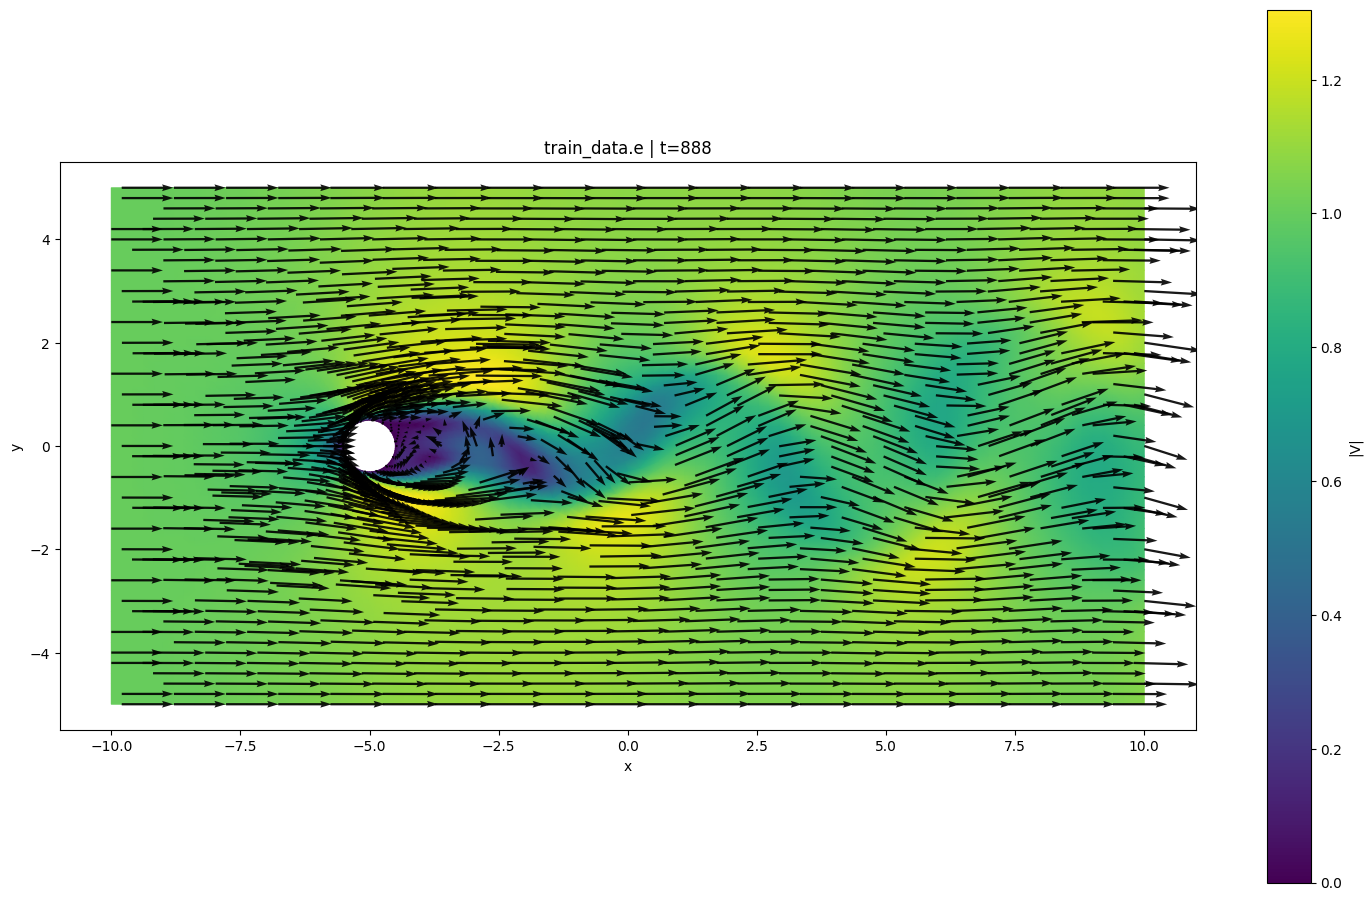

In [ ]:
plot_flow_snapshot(train_path, t_index = 888, quiver_frac=0.2)

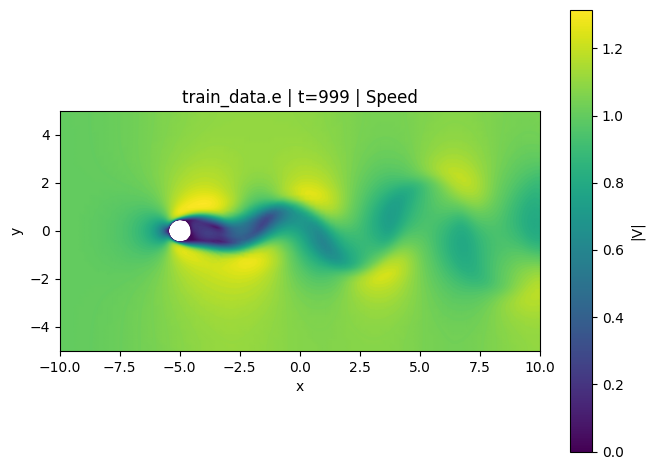

In [ ]:
plot_heatmap_contours(train_path, t_index=999, field="speed",    levels=100)

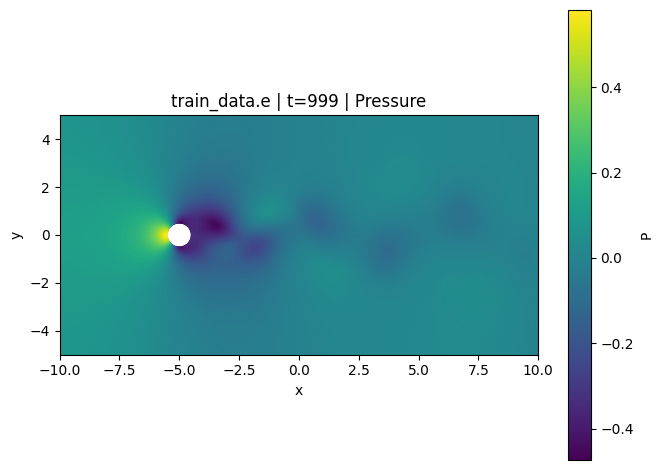

In [ ]:
#Pressure heat map:
plot_heatmap_contours(train_path, t_index=999, field="pressure", levels=100)

#### Assamble DS

In [18]:
def load_fields(path, t_start=0, t_count=None):
    """
    Load velocity (Vx, Vy) and pressure (P) from an Exodus-II file into
    (num_nodes, T) arrays, plus a stacked velocity array (2*num_nodes, T).

    Args:
        path     : str, path to *.e
        t_start  : int, first time index to load (default 0)
        t_count  : int or None, number of time steps to load (None -> to end)

    Returns:
        times    : (T,)                    time vector (subset)
        coordx   : (num_nodes,)
        coordy   : (num_nodes,)
        Vx       : (num_nodes, T)
        Vy       : (num_nodes, T)
        P        : (num_nodes, T)
        V_stack  : (2*num_nodes, T)       row-stacked [Vx; Vy]
    """
    ds = Dataset(path, "r")
    ds.set_auto_mask(False)

    # Coordinates
    coordx = ds.variables["coordx"][:]
    coordy = ds.variables["coordy"][:]
    num_nodes = coordx.size

    # Time indexing
    if "time_whole" in ds.variables:
        time_whole = ds.variables["time_whole"][:]
        n_total = time_whole.shape[0]
    else:
        # if absent, infer from one nodal var later; for now placeholder
        time_whole = None
        n_total = None

    # Nodal var names -> indices (1-based in Exodus naming)
    var_names = []
    if "name_nod_var" in ds.variables:
        var_names = [s.strip() for s in chartostring(ds.variables["name_nod_var"][:]).tolist()]

    def _find_index(target):
        """find 1-based index of a nodal var by case-insensitive match"""
        tl = target.lower()
        for i, n in enumerate(var_names, start=1):
            if n.lower() == tl:
                return i
        return None

    # Prefer explicit names; dataset shows ['V_y', 'V_x', 'P']
    ix_vx = _find_index("V_x")
    ix_vy = _find_index("V_y")
    ix_p  = _find_index("P")

    aliases = {
            "vx": ["v_x", "vx", "velocity_x", "u"],
            "vy": ["v_y", "vy", "velocity_y", "v"],
            "p" : ["p", "pressure"]
        }
    def _search_alias(cands):
        for c in cands:
            j = _find_index(c)
            if j is not None:
                return j
        return None
    ix_vx = ix_vx or _search_alias(aliases["vx"]) or 2
    ix_vy = ix_vy or _search_alias(aliases["vy"]) or 1
    ix_p  = ix_p  or _search_alias(aliases["p"])  or 3

    # Determine total steps if time_whole missing
    if n_total is None:
        key_probe = f"vals_nod_var{ix_vx}"
        n_total = ds.variables[key_probe].shape[0]

    # Build time slice
    if t_count is None:
        t_end = n_total
    else:
        t_end = min(n_total, t_start + int(t_count))
    t_slice = slice(int(t_start), int(t_end))
    T = t_end - t_start

    # Extract and transpose to (num_nodes, T)
    Vx = ds.variables[f"vals_nod_var{ix_vx}"][t_slice, :].T
    Vy = ds.variables[f"vals_nod_var{ix_vy}"][t_slice, :].T
    P  = ds.variables[f"vals_nod_var{ix_p}" ][t_slice, :].T

    ds.close()

    # Times subset
    if time_whole is None:
        times = np.arange(T, dtype=float)
    else:
        times = time_whole[t_slice]

    # Stack velocities: (2*num_nodes, T)
    V_stack = np.vstack([Vx, Vy])

    # Sanity shapes
    assert Vx.shape == (num_nodes, T)
    assert Vy.shape == (num_nodes, T)
    assert P.shape  == (num_nodes, T)
    assert V_stack.shape == (2*num_nodes, T)

    return times, coordx, coordy, Vx, Vy, P, V_stack

### DS assembly

In [19]:
times, x, y, Vx, Vy, P, V = load_fields(train_path, t_start=0, t_count=3333)
print(times.shape, Vx.shape, Vy.shape, P.shape, V.shape)

(3333,) (6569, 3333) (6569, 3333) (6569, 3333) (13138, 3333)


In [47]:
### Covariance matrix:
V = V - np.mean(V,axis = 1, keepdims=True)
COV_V = V.T @ V
UC,SC,VC = np.linalg.svd(COV_V)

Spectral Energy: 99.95025741773149 % of 75


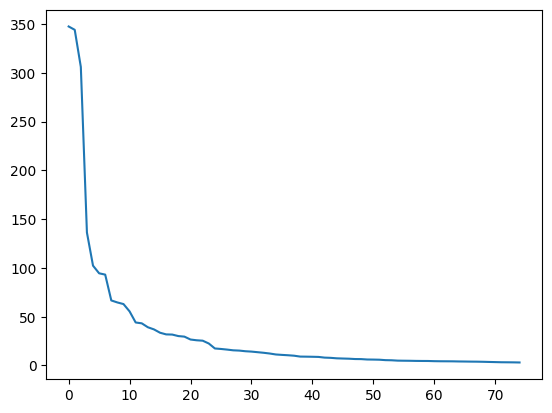

In [52]:
cut_off_ind = 75
plt.plot(np.sqrt(SC[0:cut_off_ind]))
print(f'Spectral Energy: {100 * np.sum(SC[0:cut_off_ind])/np.sum(SC)} % of {cut_off_ind}')